In [1]:
import os
import cv2
import h5py
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
df = pd.read_csv('../download/labels.csv')
synset = sorted(set(df['breed']))
# print(synset[:10])
n = len(df)
print('训练样本总数是: %s ' % n, '\n', '总共有 %s 类' % len(synset))

训练样本总数是: 10222  
 总共有 120 类


In [3]:
# 初始化样本数据，224 x 224 大小和 299 x 299 大小的两种
X_224 = np.zeros((n, 224, 224, 3))
X_299 = np.zeros((n, 299, 299, 3))

# 初始化训练标签
y = np.zeros((n,))

In [4]:
# 所有数据集的均值和方差
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [5]:
for i, (fname, breed) in tqdm(df.iterrows(), total=n):
    img = cv2.imread('../download/train/%s.jpg' % fname)

    img_224 = (cv2.resize(img, (224, 224))[:,:,::-1] / 255.0 - mean) / std
    img_299 = (cv2.resize(img, (299, 299))[:,:,::-1] / 255.0 - mean) / std

    X_224[i] = np.array(img_224)
    X_299[i] = np.array(img_299)
    
    y[i] = synset.index(breed)

100%|██████████| 10222/10222 [02:23<00:00, 70.99it/s] 


In [7]:
print(X_224.shape, X_299.shape)

(10222, 224, 224, 3) (10222, 299, 299, 3)


In [9]:
print(y.shape,y)

(10222,) [ 19.  37.  85. ...,   3.  75.  28.]


In [6]:
from keras.utils import to_categorical

y = to_categorical(y, len(synset))

Using TensorFlow backend.


In [15]:
print(y[0:3])

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 

In [7]:
# 定义一个特征抽取器
def get_features(MODEL, width, height, data=X_299, weights='imagenet'):
    from keras.models import Model, Input
#     from keras.applications.inception_v3 import preprocess_input
    from keras.applications import InceptionV3, Xception, VGG16, ResNet50
    from keras.layers import Lambda, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
    
    cnn_model = MODEL(weights=weights, include_top=False, input_shape=(width, height, 3))
    inputs = Input((width, height, 3))
    x = inputs
#     x = Lambda(preprocess_input, name='preprocessing')(x)
    x = cnn_model(x)
    x = GlobalAveragePooling2D()(x)
    cnn_model = Model(inputs, x)
    
    features = cnn_model.predict(data, batch_size=32, verbose=1)
    return features

In [8]:
from keras.applications import InceptionV3, Xception, VGG16, ResNet50

inception_features = get_features(InceptionV3, 299, 299, X_299)
xception_features  = get_features(Xception, 299, 299, X_299)

10222/10222 [==============================] - 171s   


In [9]:
vgg16_features     = get_features(VGG16, 224, 224, X_224)
resnet50_features  = get_features(ResNet50, 224, 224, X_224)

10222/10222 [==============================] - 84s    


In [10]:
print('inception_features shape:', inception_features.shape, '\n')
print('xception_features shape:', xception_features.shape, '\n')
print('vgg16_features shape:', vgg16_features.shape, '\n')
print('resnet50_features shape:', resnet50_features.shape, '\n')

inception_features shape: (10222, 2048) 

xception_features shape: (10222, 2048) 

vgg16_features shape: (10222, 512) 

resnet50_features shape: (10222, 2048) 



In [11]:
features = np.concatenate([inception_features, xception_features, vgg16_features, resnet50_features], axis=-1)

In [12]:
print('features shape:', features.shape)

features shape: (10222, 6656)


In [13]:
%%time
# 将特征使用h5py保存为hdf5格式
import h5py

with h5py.File('features.hdf5', 'w') as d:
    d['features'] = features

CPU times: user 2.4 ms, sys: 312 ms, total: 315 ms
Wall time: 491 ms


In [ ]:
# 读入特征
import h5py

with h5py.File('features.hdf5', 'r') as d:
    features = np.array(d['features'])

In [14]:
from keras.models import Model, Input
from keras.layers import Lambda, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization

inputs = Input(features.shape[1:])
x = inputs
x = Dropout(0.5)(x)
x = Dense(120, activation='softmax')(x)
ensemble_model = Model(inputs, x)
ensemble_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
h = ensemble_model.fit(features, y, batch_size=128, epochs=20, validation_split=0.3)

Train on 7155 samples, validate on 3067 samples
Epoch 1/20
7155/7155 [==============================] - 1s - loss: 2.7059 - acc: 0.4219 - val_loss: 1.0460 - val_acc: 0.7542
Epoch 2/20
7155/7155 [==============================] - 0s - loss: 0.7395 - acc: 0.8196 - val_loss: 0.7083 - val_acc: 0.8080
Epoch 3/20
7155/7155 [==============================] - 0s - loss: 0.4787 - acc: 0.8773 - val_loss: 0.6322 - val_acc: 0.8164
Epoch 4/20
7155/7155 [==============================] - 0s - loss: 0.3553 - acc: 0.9107 - val_loss: 0.5708 - val_acc: 0.8210
Epoch 5/20
7155/7155 [==============================] - 0s - loss: 0.2740 - acc: 0.9365 - val_loss: 0.5597 - val_acc: 0.8243
Epoch 6/20
7155/7155 [==============================] - 0s - loss: 0.2097 - acc: 0.9535 - val_loss: 0.5289 - val_acc: 0.8366
Epoch 7/20
7155/7155 [==============================] - 0s - loss: 0.1681 - acc: 0.9665 - val_loss: 0.5240 - val_acc: 0.8324
Epoch 8/20
7155/7155 [==============================] - 0s - loss: 0.1393 - a

In [15]:
ensemble_model.save('m12820_01.h5')

In [16]:
h = ensemble_model.fit(features, y, batch_size=128, epochs=50, validation_split=0.3)

Train on 7155 samples, validate on 3067 samples
Epoch 1/50
7155/7155 [==============================] - 0s - loss: 0.0327 - acc: 0.9980 - val_loss: 0.4930 - val_acc: 0.8428
Epoch 2/50
7155/7155 [==============================] - 0s - loss: 0.0306 - acc: 0.9975 - val_loss: 0.5011 - val_acc: 0.8406
Epoch 3/50
7155/7155 [==============================] - 0s - loss: 0.0294 - acc: 0.9971 - val_loss: 0.4941 - val_acc: 0.8432
Epoch 4/50
7155/7155 [==============================] - 0s - loss: 0.0275 - acc: 0.9976 - val_loss: 0.4955 - val_acc: 0.8432
Epoch 5/50
7155/7155 [==============================] - 0s - loss: 0.0245 - acc: 0.9985 - val_loss: 0.5016 - val_acc: 0.8471
Epoch 6/50
7155/7155 [==============================] - 0s - loss: 0.0244 - acc: 0.9985 - val_loss: 0.4948 - val_acc: 0.8451
Epoch 7/50
7155/7155 [==============================] - 0s - loss: 0.0224 - acc: 0.9987 - val_loss: 0.5000 - val_acc: 0.8409
Epoch 8/50
7155/7155 [==============================] - 0s - loss: 0.0203 - a

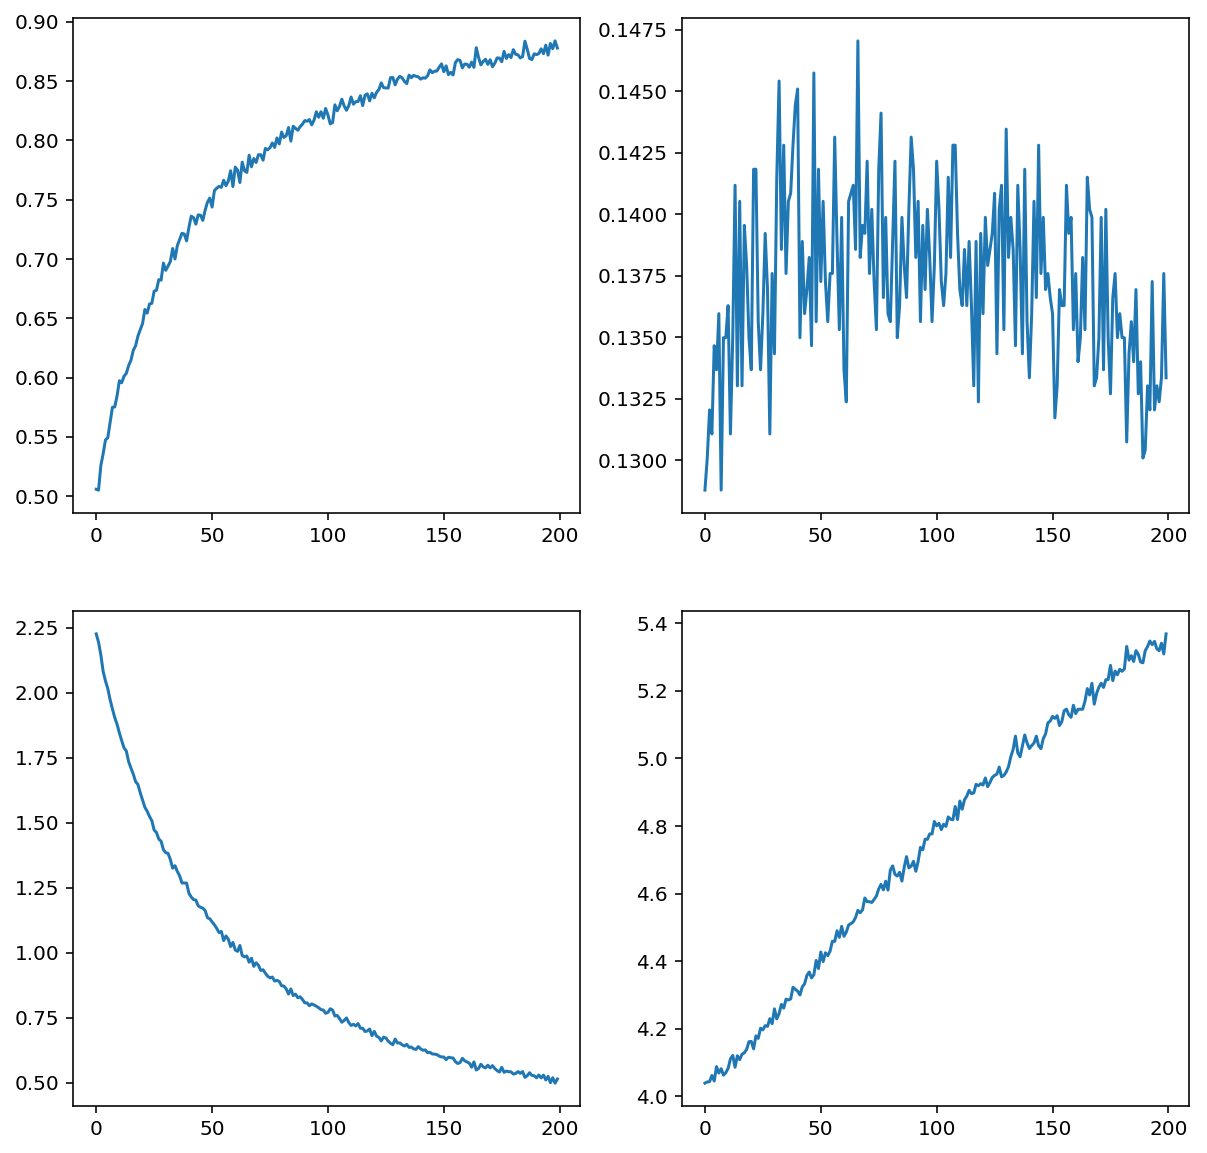

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

f,axes = plt.subplots(2,2,figsize=(10,10))
ax = axes.flatten()

his = ensemble_model.history
log = his.history


ax[0].plot(range(200), log['acc'])
ax[1].plot(range(200), log['val_acc'])
ax[2].plot(range(200), log['loss'])
ax[3].plot(range(200), log['val_loss'])

In [17]:
df_test = pd.read_csv('../download/sample_submission.csv')
n_test = len(df_test)

X_224_test = np.zeros((n_test, 224, 224, 3))
X_299_test = np.zeros((n_test, 299, 299, 3))

for i, fname in tqdm(enumerate(df_test['id']), total=n_test):
    img = cv2.imread('../download/test/%s.jpg' % fname)
    img_224 = (cv2.resize(img, (224, 224))[:,:,::-1] / 255.0 - mean) / std
    img_299 = (cv2.resize(img, (299, 299))[:,:,::-1] / 255.0 - mean) / std
    
    X_224_test[i] = np.array(img_224)
    X_299_test[i] = np.array(img_299)
print(X_224_test.shape, X_299_test.shape)

100%|██████████| 10357/10357 [02:40<00:00, 64.58it/s]

(10357, 224, 224, 3) (10357, 299, 299, 3)


In [18]:
ince_features_test = get_features(InceptionV3, 299, 299, X_299_test)
xcep_features_test = get_features(Xception, 299, 299, X_299_test)

vgg16_features_test = get_features(VGG16, 224, 224, X_224_test)
resnet50_features_test = get_features(ResNet50, 224, 224, X_224_test)

10357/10357 [==============================] - 87s    


In [26]:
features_test = np.concatenate([ince_features_test, xcep_features_test, 
                                vgg16_features_test, resnet50_features_test], axis=-1)
print(features_test.shape)

(10357, 6656)


In [38]:
# 将特征使用h5py保存为hdf5格式
import h5py

with h5py.File('features_test.hdf5', 'w') as d:
    d['features_test'] = features_test

In [27]:
from keras.models import load_model

pred_model = load_model('m12820_01.h5')

In [28]:
%%time
y_pred = pred_model.predict(features_test, batch_size=64)

CPU times: user 2.03 s, sys: 166 ms, total: 2.2 s
Wall time: 2.07 s


In [29]:
print(y_pred.shape, '\n', y_pred)

(10357, 120) 
 [[  9.75622470e-07   5.53976008e-07   4.01955617e-07 ...,   3.24518908e-07
    1.35082189e-06   1.61987043e-06]
 [  2.60666866e-06   1.31854790e-07   2.81087750e-07 ...,   4.97276119e-07
    2.60647630e-05   1.50076357e-06]
 [  8.49107039e-07   2.65053968e-04   7.98801466e-06 ...,   4.03720651e-06
    4.45418164e-06   3.78539539e-06]
 ..., 
 [  2.85711167e-06   1.09830705e-06   2.53852544e-04 ...,   1.01660044e-06
    2.96953226e-06   5.70333759e-06]
 [  9.58766250e-05   7.81146900e-06   9.06217974e-06 ...,   1.84340388e-06
    1.37674269e-05   9.75715171e-04]
 [  1.70699991e-07   7.69295821e-06   4.43436284e-06 ...,   6.97036376e-05
    9.83371592e-07   1.59082951e-08]]


In [33]:
print(y_pred[0].clip(min=0.001, max=0.995))

[ 0.001       0.001       0.001       0.001       0.001       0.001       0.001
  0.001       0.001       0.001       0.001       0.001       0.001       0.001
  0.001       0.001       0.001       0.001       0.001       0.001       0.001
  0.001       0.001       0.001       0.001       0.001       0.001       0.001
  0.001       0.001       0.001       0.001       0.001       0.001       0.001
  0.001       0.001       0.001       0.001       0.001       0.001       0.001
  0.001       0.001       0.001       0.001       0.001       0.001       0.001
  0.001       0.001       0.001       0.001       0.001       0.001       0.001
  0.001       0.001       0.001       0.001       0.001       0.9844662
  0.001       0.001       0.001       0.001       0.001       0.001       0.001
  0.001       0.001       0.001       0.001       0.001       0.001       0.001
  0.001       0.001       0.001       0.001       0.001       0.001       0.001
  0.001       0.001       0.01530803  0.001     

In [58]:
from pandas import DataFrame
data1 = DataFrame(y_pred)
data1.to_csv('arr1.csv')

In [113]:
data1.insert(0, 'id', df_test['id'])
data1

,id,0,1,2,3,4,5,6,7,8,...,110,111,112,113,114,115,116,117,118,119
0,000621fb3cbb32d8935728e48679680e,9.756225e-07,5.539760e-07,4.019556e-07,5.064198e-08,4.704900e-08,1.650130e-08,1.357565e-07,5.426276e-08,1.379387e-07,...,4.683731e-07,3.177835e-08,1.871791e-07,1.023695e-07,1.299507e-07,1.832404e-07,9.944308e-08,3.245189e-07,1.350822e-06,1.619870e-06
1,00102ee9d8eb90812350685311fe5890,2.606669e-06,1.318548e-07,2.810878e-07,8.970241e-07,7.117787e-07,1.446489e-06,1.309511e-06,1.923320e-06,2.474471e-07,...,1.664255e-05,2.159200e-06,5.138759e-08,2.216280e-06,1.709980e-07,3.226568e-07,3.066569e-04,4.972761e-07,2.606476e-05,1.500764e-06
2,0012a730dfa437f5f3613fb75efcd4ce,8.491070e-07,2.650540e-04,7.988015e-06,1.953461e-06,5.948435e-08,5.162311e-06,5.698099e-08,1.038070e-07,7.758896e-06,...,1.785541e-07,8.102754e-07,6.404249e-06,2.378334e-04,2.734608e-05,1.034556e-02,6.999915e-07,4.037207e-06,4.454182e-06,3.785395e-06
3,001510bc8570bbeee98c8d80c8a95ec1,1.489713e-03,9.329511e-05,5.063377e-05,4.271636e-04,5.980529e-05,2.220849e-05,1.257335e-05,3.260862e-04,7.790211e-04,...,1.732415e-05,3.283790e-06,8.523274e-06,6.311856e-05,2.254149e-05,1.498989e-05,2.175559e-06,2.673011e-03,5.388652e-05,4.125449e-05
4,001a5f3114548acdefa3d4da05474c2e,1.859579e-03,3.495307e-05,2.588092e-06,1.764897e-07,4.987562e-07,6.152113e-07,1.526783e-05,2.720932e-06,3.061082e-06,...,2.354328e-06,1.015202e-05,3.239815e-07,2.128868e-06,4.612191e-07,1.523464e-06,4.921289e-06,1.293971e-05,1.308509e-04,2.705769e-05
5,00225dcd3e4d2410dd53239f95c0352f,2.932123e-06,3.892038e-03,1.385294e-05,2.269669e-03,6.959018e-07,5.116989e-07,1.424913e-07,1.003164e-05,7.129545e-07,...,1.026424e-02,7.123326e-07,8.906086e-07,3.978897e-06,1.421157e-06,1.101981e-06,8.555535e-07,3.305600e-06,4.139133e-03,1.382971e-06
6,002c2a3117c2193b4d26400ce431eebd,1.811929e-06,8.105523e-08,5.227415e-07,1.049919e-06,5.118900e-08,5.809109e-08,9.993607e-01,1.997393e-07,2.724415e-08,...,2.284894e-07,3.027047e-07,4.416849e-07,2.055963e-08,1.265891e-08,1.258408e-07,7.060748e-08,5.520048e-08,5.195962e-06,1.452077e-05
7,002c58d413a521ae8d1a5daeb35fc803,9.545704e-07,2.984774e-07,1.312482e-06,1.910374e-07,9.828412e-07,6.635514e-07,2.902455e-06,1.491353e-06,2.807141e-07,...,1.450116e-05,2.485984e-07,1.128658e-07,3.609497e-07,5.494271e-07,2.425898e-07,1.974993e-03,1.008613e-06,2.955483e-05,7.390921e-06
8,002f80396f1e3db687c5932d7978b196,3.329168e-06,3.065466e-07,2.020630e-06,1.897313e-05,2.328212e-06,1.741866e-07,4.997182e-08,8.146329e-08,1.063445e-07,...,2.898073e-08,7.661049e-08,5.742218e-06,1.725683e-06,1.311341e-06,1.325146e-06,2.445868e-07,4.244090e-05,2.612627e-05,4.400990e-08
9,0036c6bcec6031be9e62a257b1c3c442,2.591452e-07,5.103691e-07,1.268727e-06,4.383877e-08,1.446094e-05,7.216785e-08,2.178134e-06,7.939630e-08,4.069761e-06,...,8.518747e-07,5.613977e-08,1.166582e-05,8.997444e-07,9.709634e-06,1.193822e-05,5.884441e-08,3.845545e-07,1.250642e-05,3.326951e-07


In [114]:
data1.columns = df_test.columns[:]
data1

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,9.756225e-07,5.539760e-07,4.019556e-07,5.064198e-08,4.704900e-08,1.650130e-08,1.357565e-07,5.426276e-08,1.379387e-07,...,4.683731e-07,3.177835e-08,1.871791e-07,1.023695e-07,1.299507e-07,1.832404e-07,9.944308e-08,3.245189e-07,1.350822e-06,1.619870e-06
1,00102ee9d8eb90812350685311fe5890,2.606669e-06,1.318548e-07,2.810878e-07,8.970241e-07,7.117787e-07,1.446489e-06,1.309511e-06,1.923320e-06,2.474471e-07,...,1.664255e-05,2.159200e-06,5.138759e-08,2.216280e-06,1.709980e-07,3.226568e-07,3.066569e-04,4.972761e-07,2.606476e-05,1.500764e-06
2,0012a730dfa437f5f3613fb75efcd4ce,8.491070e-07,2.650540e-04,7.988015e-06,1.953461e-06,5.948435e-08,5.162311e-06,5.698099e-08,1.038070e-07,7.758896e-06,...,1.785541e-07,8.102754e-07,6.404249e-06,2.378334e-04,2.734608e-05,1.034556e-02,6.999915e-07,4.037207e-06,4.454182e-06,3.785395e-06
3,001510bc8570bbeee98c8d80c8a95ec1,1.489713e-03,9.329511e-05,5.063377e-05,4.271636e-04,5.980529e-05,2.220849e-05,1.257335e-05,3.260862e-04,7.790211e-04,...,1.732415e-05,3.283790e-06,8.523274e-06,6.311856e-05,2.254149e-05,1.498989e-05,2.175559e-06,2.673011e-03,5.388652e-05,4.125449e-05
4,001a5f3114548acdefa3d4da05474c2e,1.859579e-03,3.495307e-05,2.588092e-06,1.764897e-07,4.987562e-07,6.152113e-07,1.526783e-05,2.720932e-06,3.061082e-06,...,2.354328e-06,1.015202e-05,3.239815e-07,2.128868e-06,4.612191e-07,1.523464e-06,4.921289e-06,1.293971e-05,1.308509e-04,2.705769e-05
5,00225dcd3e4d2410dd53239f95c0352f,2.932123e-06,3.892038e-03,1.385294e-05,2.269669e-03,6.959018e-07,5.116989e-07,1.424913e-07,1.003164e-05,7.129545e-07,...,1.026424e-02,7.123326e-07,8.906086e-07,3.978897e-06,1.421157e-06,1.101981e-06,8.555535e-07,3.305600e-06,4.139133e-03,1.382971e-06
6,002c2a3117c2193b4d26400ce431eebd,1.811929e-06,8.105523e-08,5.227415e-07,1.049919e-06,5.118900e-08,5.809109e-08,9.993607e-01,1.997393e-07,2.724415e-08,...,2.284894e-07,3.027047e-07,4.416849e-07,2.055963e-08,1.265891e-08,1.258408e-07,7.060748e-08,5.520048e-08,5.195962e-06,1.452077e-05
7,002c58d413a521ae8d1a5daeb35fc803,9.545704e-07,2.984774e-07,1.312482e-06,1.910374e-07,9.828412e-07,6.635514e-07,2.902455e-06,1.491353e-06,2.807141e-07,...,1.450116e-05,2.485984e-07,1.128658e-07,3.609497e-07,5.494271e-07,2.425898e-07,1.974993e-03,1.008613e-06,2.955483e-05,7.390921e-06
8,002f80396f1e3db687c5932d7978b196,3.329168e-06,3.065466e-07,2.020630e-06,1.897313e-05,2.328212e-06,1.741866e-07,4.997182e-08,8.146329e-08,1.063445e-07,...,2.898073e-08,7.661049e-08,5.742218e-06,1.725683e-06,1.311341e-06,1.325146e-06,2.445868e-07,4.244090e-05,2.612627e-05,4.400990e-08
9,0036c6bcec6031be9e62a257b1c3c442,2.591452e-07,5.103691e-07,1.268727e-06,4.383877e-08,1.446094e-05,7.216785e-08,2.178134e-06,7.939630e-08,4.069761e-06,...,8.518747e-07,5.613977e-08,1.166582e-05,8.997444e-07,9.709634e-06,1.193822e-05,5.884441e-08,3.845545e-07,1.250642e-05,3.326951e-07


In [115]:
data1.to_csv('pred_test121001.csv', index=None)

In [ ]:
df_test = pd.read_csv('sample_submission.csv')
df_test[1:] = y_pred
df_test.to_csv('pred_test.csv', index=None)

In [86]:
data2 = DataFrame(y_pred.clip(min=0.001, max=0.995))
tmp_file = DataFrame(data2, columns=df_test.columns[1:], index=df_test['id']) 

In [77]:
data2.to_csv('arr3.csv')

In [87]:
data2

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001,0.001000,...,0.001000,0.001000,0.001,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000
1,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001,0.001000,...,0.001000,0.001000,0.001,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000
2,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001,0.001000,...,0.001000,0.001000,0.001,0.001000,0.001000,0.010346,0.001000,0.001000,0.001000,0.001000
3,0.001490,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001,0.001000,...,0.001000,0.001000,0.001,0.001000,0.001000,0.001000,0.001000,0.002673,0.001000,0.001000
4,0.001860,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001,0.001000,...,0.001000,0.001000,0.001,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000
5,0.001000,0.003892,0.001000,0.002270,0.001000,0.001000,0.001000,0.001000,0.001,0.001000,...,0.010264,0.001000,0.001,0.001000,0.001000,0.001000,0.001000,0.001000,0.004139,0.001000
6,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.995000,0.001000,0.001,0.001000,...,0.001000,0.001000,0.001,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000
7,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001,0.001000,...,0.001000,0.001000,0.001,0.001000,0.001000,0.001000,0.001975,0.001000,0.001000,0.001000
8,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001,0.001000,...,0.001000,0.001000,0.001,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000
9,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001,0.001000,...,0.001000,0.001000,0.001,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000


In [88]:
data2.insert(0, 'id', df_test['id'])
data2

,id,0,1,2,3,4,5,6,7,8,...,110,111,112,113,114,115,116,117,118,119
0,000621fb3cbb32d8935728e48679680e,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001,...,0.001000,0.001000,0.001,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000
1,00102ee9d8eb90812350685311fe5890,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001,...,0.001000,0.001000,0.001,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000
2,0012a730dfa437f5f3613fb75efcd4ce,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001,...,0.001000,0.001000,0.001,0.001000,0.001000,0.010346,0.001000,0.001000,0.001000,0.001000
3,001510bc8570bbeee98c8d80c8a95ec1,0.001490,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001,...,0.001000,0.001000,0.001,0.001000,0.001000,0.001000,0.001000,0.002673,0.001000,0.001000
4,001a5f3114548acdefa3d4da05474c2e,0.001860,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001,...,0.001000,0.001000,0.001,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000
5,00225dcd3e4d2410dd53239f95c0352f,0.001000,0.003892,0.001000,0.002270,0.001000,0.001000,0.001000,0.001000,0.001,...,0.010264,0.001000,0.001,0.001000,0.001000,0.001000,0.001000,0.001000,0.004139,0.001000
6,002c2a3117c2193b4d26400ce431eebd,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.995000,0.001000,0.001,...,0.001000,0.001000,0.001,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000
7,002c58d413a521ae8d1a5daeb35fc803,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001,...,0.001000,0.001000,0.001,0.001000,0.001000,0.001000,0.001975,0.001000,0.001000,0.001000
8,002f80396f1e3db687c5932d7978b196,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001,...,0.001000,0.001000,0.001,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000
9,0036c6bcec6031be9e62a257b1c3c442,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001,...,0.001000,0.001000,0.001,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000


In [93]:
data2.columns[:]

Index(['id',    0,    1,    2,    3,    4,    5,    6,    7,    8,
       ...
        110,  111,  112,  113,  114,  115,  116,  117,  118,  119],
      dtype='object', length=121)

In [103]:
data2.columns = df_test.columns[:]
data2

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001,...,0.001000,0.001000,0.001,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000
1,00102ee9d8eb90812350685311fe5890,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001,...,0.001000,0.001000,0.001,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000
2,0012a730dfa437f5f3613fb75efcd4ce,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001,...,0.001000,0.001000,0.001,0.001000,0.001000,0.010346,0.001000,0.001000,0.001000,0.001000
3,001510bc8570bbeee98c8d80c8a95ec1,0.001490,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001,...,0.001000,0.001000,0.001,0.001000,0.001000,0.001000,0.001000,0.002673,0.001000,0.001000
4,001a5f3114548acdefa3d4da05474c2e,0.001860,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001,...,0.001000,0.001000,0.001,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000
5,00225dcd3e4d2410dd53239f95c0352f,0.001000,0.003892,0.001000,0.002270,0.001000,0.001000,0.001000,0.001000,0.001,...,0.010264,0.001000,0.001,0.001000,0.001000,0.001000,0.001000,0.001000,0.004139,0.001000
6,002c2a3117c2193b4d26400ce431eebd,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.995000,0.001000,0.001,...,0.001000,0.001000,0.001,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000
7,002c58d413a521ae8d1a5daeb35fc803,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001,...,0.001000,0.001000,0.001,0.001000,0.001000,0.001000,0.001975,0.001000,0.001000,0.001000
8,002f80396f1e3db687c5932d7978b196,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001,...,0.001000,0.001000,0.001,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000
9,0036c6bcec6031be9e62a257b1c3c442,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001,...,0.001000,0.001000,0.001,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000


In [104]:
data2.to_csv('pred_test1210.csv')

In [73]:
tmp_file.to_csv('arr2.csv')

In [65]:
df_test.columns

Index(['id', 'affenpinscher', 'afghan_hound', 'african_hunting_dog',
       'airedale', 'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset',
       ...
       'toy_poodle', 'toy_terrier', 'vizsla', 'walker_hound', 'weimaraner',
       'welsh_springer_spaniel', 'west_highland_white_terrier', 'whippet',
       'wire-haired_fox_terrier', 'yorkshire_terrier'],
      dtype='object', length=121)

In [66]:
df_test.columns[1:]

Index(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller', 'australian_terrier',
       'basenji', 'basset', 'beagle',
       ...
       'toy_poodle', 'toy_terrier', 'vizsla', 'walker_hound', 'weimaraner',
       'welsh_springer_spaniel', 'west_highland_white_terrier', 'whippet',
       'wire-haired_fox_terrier', 'yorkshire_terrier'],
      dtype='object', length=120)

In [ ]:
# 生成提交文件，提交预测结果
import pandas as pd

df_test = pd.read_csv('../download/sample_submission.csv')
df_test['id'] = y_pred.clip(min=0.005, max=0.995)
df.to_csv('pred.csv', index=None)

In [25]:
label_y = []
print(synset)

['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale', 'american_staffordshire_terrier', 'appenzeller', 'australian_terrier', 'basenji', 'basset', 'beagle', 'bedlington_terrier', 'bernese_mountain_dog', 'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound', 'bluetick', 'border_collie', 'border_terrier', 'borzoi', 'boston_bull', 'bouvier_des_flandres', 'boxer', 'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff', 'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo', 'doberman', 'english_foxhound', 'english_setter', 'english_springer', 'entlebucher', 'eskimo_dog', 'flat-coated_retriever', 'french_bulldog', 'german_shepherd', 'german_short-haired_pointer', 'giant_schnauzer', 'golden_retriever', 'gordon_setter', 'great_dane', 'great_pyrenees', 'greater_swiss_mountain_dog', 'groenendael', 'ibizan_hound', 'irish_setter', 'irish_terrier', 'iris

In [24]:
for i in tqdm(df.iterrows()):
    label_y[i] = synset.index(breed)
print(label_y)

0it [00:00, ?it/s]


TypeError: list indices must be integers or slices, not tuple